In [5]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import rasterio
from rasterio.io import MemoryFile
from rasterio.mask import mask
from rasterio.transform import from_origin
from rasterio.mask import mask
import geopandas as gpd

# Quick Demo

## Load data

In [6]:
path = '../../example_data/'
data_hand = sio.loadmat(path+'hand_data.mat')['img']
data_hec = sio.loadmat(path+'hec_data.mat')['img']
data_terrain = sio.loadmat(path+'terrain_data.mat')['img'][:, :]
data_slope = sio.loadmat(path+'slope_data.mat')['img'][:, :]
data_aspect = sio.loadmat(path+'aspect_data.mat')['img'][:, :]
data_lulc = sio.loadmat(path+'lulc_data.mat')['img'][:, :]
data_imper = sio.loadmat(path+'imper_data.mat')['img'][:, :]
data_hand.shape, data_hec.shape, data_terrain.shape, data_slope.shape, data_aspect.shape, \
data_lulc.shape, data_imper.shape

((5457, 5626),
 (5457, 5626),
 (5457, 5626),
 (5457, 5626),
 (5457, 5626),
 (5457, 5626),
 (5457, 5626))

In [7]:
# check the data_hand and data_hec show the correct values, 1 for flooded, -1 for dry, 0 for not-study-area mask
np.unique(data_hand), np.unique(data_hec)

(array([-1,  0,  1]), array([-1.,  0.,  1.], dtype=float32))

In [8]:
data_X_list = [data_hand, data_hec, data_terrain, data_slope, data_aspect, data_lulc, data_imper]
[p.shape for p in data_X_list]

[(5457, 5626),
 (5457, 5626),
 (5457, 5626),
 (5457, 5626),
 (5457, 5626),
 (5457, 5626),
 (5457, 5626)]

### Show the HAND-FIM and HEC-RAS

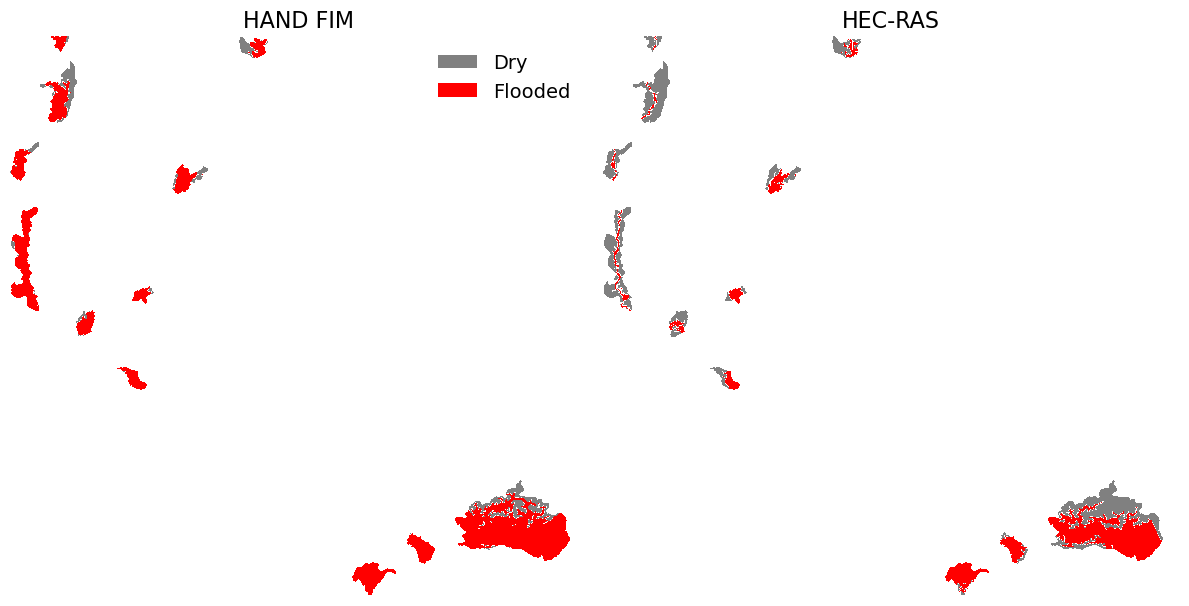

In [9]:
import matplotlib.colors as colors

cmap = colors.ListedColormap(['gray', 'white', 'red'])

def map_colors(data):
    return cmap([(data == -1)*0 + (data == 0)*1 + (data == 1)*2])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
ax.set_title('HAND FIM', fontsize=16)
im = ax.imshow(data_hand, cmap=cmap)
ax.axis('off')

color_list = ['gray', 'r']
labels = ['Dry', 'Flooded']
for i in range(2):
    ax.bar([np.nan], [np.nan], color=color_list[i], label=labels[i])
ax.legend(frameon=False, fontsize=14, loc='best')

ax = axs[1]
ax.set_title('HEC-RAS', fontsize=16)
im = ax.imshow(data_hec, cmap=cmap)
ax.axis('off')

plt.tight_layout()
plt.show()

### Get the whole figure for the final show

In [10]:
def get_figures(data_X_list):
    fig = [data_X for data_X in data_X_list]
    mask_non_zero_ras = fig[1]!=0
    loc_info = np.where(mask_non_zero_ras)
    return fig, mask_non_zero_ras, loc_info

def process_matrix_to_list(fig, mask):
    return fig[mask]

In [11]:
pic, mask_non_zero_ras, loc_info = get_figures(data_X_list)
pic[0].shape

(5457, 5626)

In [12]:
dataX = np.stack([process_matrix_to_list(data_X_list[0], mask_non_zero_ras)]+\
                 [process_matrix_to_list(data_X_list[i], mask_non_zero_ras) for i in range(2, len(data_X_list))], axis=1)
dataX[np.isnan(dataX)] = 0
datay = process_matrix_to_list(pic[1], mask_non_zero_ras)
dataX.shape, datay.shape

((1016191, 6), (1016191,))

In [13]:
np.isnan(dataX).sum(), np.isnan(datay).sum()

(0, 0)

### Prepare for metrics

In [14]:
def POD(obs, sim):
    detected = (obs==1)&(sim==1)
    missed = (obs==1)&(sim==-1)
    return sum(detected)/(sum(missed)+sum(detected))

def RFA(obs, sim):
    false_alarm = (obs==-1)&(sim==1)
    detected = (obs==1)&(sim==1)
    return sum(false_alarm)/(sum(false_alarm)+sum(detected))

def CSI(obs, sim):
    detected = (obs==1)&(sim==1)
    missed = (obs==1)&(sim==-1)
    false_alarm = (obs==-1)&(sim==1)
    return sum(detected)/(sum(false_alarm)+sum(detected)+sum(missed))

### Pre-processing for the data input

In [20]:
def get_train_test_x_y(data, path_data_shp):
    shapes = gpd.read_file('../../example_data/train_test_all/train_test_all.shp')
    minx, miny, maxx, maxy = shapes.total_bounds
    extent = [minx, maxx, miny, maxy]
    pixel_width = (maxx - minx)/data.shape[1]
    pixel_height = (maxy - miny)/data.shape[0]
    transform = from_origin(minx, maxy, pixel_width, pixel_height)

    crs = shapes.crs
    with MemoryFile() as memfile:
        with memfile.open(driver='GTiff', 
                        height=data.shape[0], width=data.shape[1], count=1, dtype=str(data.dtype),
                        crs=crs, transform=transform) as dst:
            dst.write(data, 1)
            dst.close()

        with memfile.open() as src:
            shapes = gpd.read_file(path_data_shp)
            shapes = shapes.to_crs(src.crs)

            geoms = shapes.geometry.values
            geoms = [geom.__geo_interface__ for geom in geoms]

            out_image_new, _ = mask(src, geoms, crop=True)
            out_image = out_image_new.squeeze()
            src.close()
    return out_image

In [21]:
train_path = '../../example_data/train_all/train_all.shp'
train_hec = get_train_test_x_y(data_hec, train_path)
train_hec.shape

(5146, 5626)

In [22]:
path = '../../example_data/'
data_hand = sio.loadmat(path+'hand_data.mat')['img']
data_hec = sio.loadmat(path+'hec_data.mat')['img']
data_terrain = sio.loadmat(path+'terrain_data.mat')['img'][:, :]
data_slope = sio.loadmat(path+'slope_data.mat')['img'][:, :]
data_aspect = sio.loadmat(path+'aspect_data.mat')['img'][:, :]
data_lulc = sio.loadmat(path+'lulc_data.mat')['img'][:, :]
data_imper = sio.loadmat(path+'imper_data.mat')['img'][:, :]
data_X_list = [data_hand, data_hec, data_terrain, data_slope, data_aspect, data_lulc, data_imper]

train_X_list = [get_train_test_x_y(data, train_path) for data in data_X_list]
train_X_list[0].shape

(5146, 5626)

In [23]:
test_path = '../../example_data/test_all/test_all.shp'
test_hec = get_train_test_x_y(data_hec, test_path)
test_hec.shape

(5451, 3466)

In [24]:
path = '../../example_data/'
data_hand = sio.loadmat(path+'hand_data.mat')['img']
data_hec = sio.loadmat(path+'hec_data.mat')['img']
data_terrain = sio.loadmat(path+'terrain_data.mat')['img'][:, :]
data_slope = sio.loadmat(path+'slope_data.mat')['img'][:, :]
data_aspect = sio.loadmat(path+'aspect_data.mat')['img'][:, :]
data_lulc = sio.loadmat(path+'lulc_data.mat')['img'][:, :]
data_imper = sio.loadmat(path+'imper_data.mat')['img'][:, :]
data_X_list = [data_hand, data_hec, data_terrain, data_slope, data_aspect, data_lulc, data_imper]

test_X_list = [get_train_test_x_y(data, test_path) for data in data_X_list]
test_X_list[0].shape

(5451, 3466)

In [25]:
fig_train, mask_train, loc_info_train = get_figures(train_X_list)
dataX_train = np.stack([process_matrix_to_list(train_X_list[0], mask_train)]+\
                 [process_matrix_to_list(train_X_list[i], mask_train) for i in range(2, len(train_X_list))], axis=1)
dataX_train[np.isnan(dataX_train)] = 0
datay_train = process_matrix_to_list(fig_train[1], mask_train)
dataX_train.shape, datay_train.shape

((788679, 6), (788679,))

In [26]:
fig_test, mask_test, loc_info_test = get_figures(test_X_list)
dataX_test = np.stack([process_matrix_to_list(test_X_list[0], mask_test)]+\
                 [process_matrix_to_list(test_X_list[i], mask_test) for i in range(2, len(test_X_list))], axis=1)
dataX_test[np.isnan(dataX_test)] = 0
datay_test = process_matrix_to_list(fig_test[1], mask_test)
dataX_test.shape, datay_test.shape

((220308, 6), (220308,))

In [22]:
train_X_list[0].shape, test_X_list[0].shape

((5146, 5626), (5451, 3466))

### Train the model

#### Hand-on way (adjust the hyperparameter manually)

In [95]:
from sklearn.ensemble import RandomForestClassifier

class_weights = {-1: 1, 1: 10}

rf = RandomForestClassifier(n_estimators=1500, min_samples_leaf=3, 
                            max_depth=50, random_state=5, max_leaf_nodes=50, 
                            n_jobs=8, class_weight=class_weights).fit(dataX_train, datay_train)

#### Automatic search the optimal one

In [23]:
from sklearn.metrics import make_scorer

def custom_loss_function(y_true, y_pred, *args, **kwargs):
    detected = (y_true==1)&(y_pred==1)
    missed = (y_true==1)&(y_pred==-1)
    false_alarm = (y_true==-1)&(y_pred==1)
    return sum(detected)/(sum(false_alarm)+sum(detected)+sum(missed))

custom_loss = make_scorer(custom_loss_function, greater_is_better=True)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid (adjust it yourself for better results)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 800, 1000],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_depth': [5, 10, 20, 30, 50],
    'max_leaf_nodes': [10, 20, 30, 50]
}

n_jobs = 8
rf = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, scoring=custom_loss, n_jobs=n_jobs)

grid_search.fit(dataX_train, datay_train)

best_params = grid_search.best_params_
best_params

In [ ]:
from joblib import dump
# Save the model with maximum compression
dump(rf, '../../example_data/saved_model/rf_model_demo.joblib', compress=9)

### Use well-trained model

In [28]:
from joblib import load
rf = load('../../example_data/saved_model/rf_model_demo.joblib')
rf

RandomForestClassifier(class_weight={-1: 1, 1: 20}, max_depth=80,
                       max_leaf_nodes=80, min_samples_leaf=3, n_estimators=1500,
                       n_jobs=8, random_state=5)

In [25]:
predy_train = rf.predict(dataX_train)
predy_test = rf.predict(dataX_test)

ymatr_tr = np.zeros(fig_train[1].shape)
ymatr_tr[mask_train] = predy_train

ymatr_te = np.zeros(fig_test[1].shape)
ymatr_te[mask_test] = predy_test

In [26]:
df_performance = pd.DataFrame(data=np.full((3, 2), np.nan), columns=['Train', 'Test'], index=['CSI', 'POD', 'RFA'])
df_performance.iloc[0] = CSI(datay_train, predy_train), CSI(datay_test, predy_test)
df_performance.iloc[1] = POD(datay_train, predy_train), POD(datay_test, predy_test)
df_performance.iloc[2] = RFA(datay_train, predy_train), RFA(datay_test, predy_test)
df_performance

,Train,Test
CSI,0.716553,0.709181
POD,0.999317,0.999136
RFA,0.283096,0.290384


#### Compare to the HAND-FIM (HEC-RAS as the target)

In [27]:
df_hand_hec = pd.DataFrame(data=np.full((3, 2), np.nan), columns=['Train', 'Test'], index=['CSI', 'POD', 'RFA'])
df_hand_hec.iloc[:, 0] = CSI(datay_train, dataX_train[:, 0]), POD(datay_train, dataX_train[:, 0]), RFA(datay_train, dataX_train[:, 0])
df_hand_hec.iloc[:, 1] = CSI(datay_test, dataX_test[:, 0]), POD(datay_test, dataX_test[:, 0]), RFA(datay_test, dataX_test[:, 0])
df_hand_hec

,Train,Test
CSI,0.601819,0.528365
POD,0.999928,1.000000
RFA,0.398155,0.471635


### For the whole map

In [28]:
predy = rf.predict(dataX)

ymatr = np.zeros(pic[1].shape)
ymatr[mask_non_zero_ras] = predy

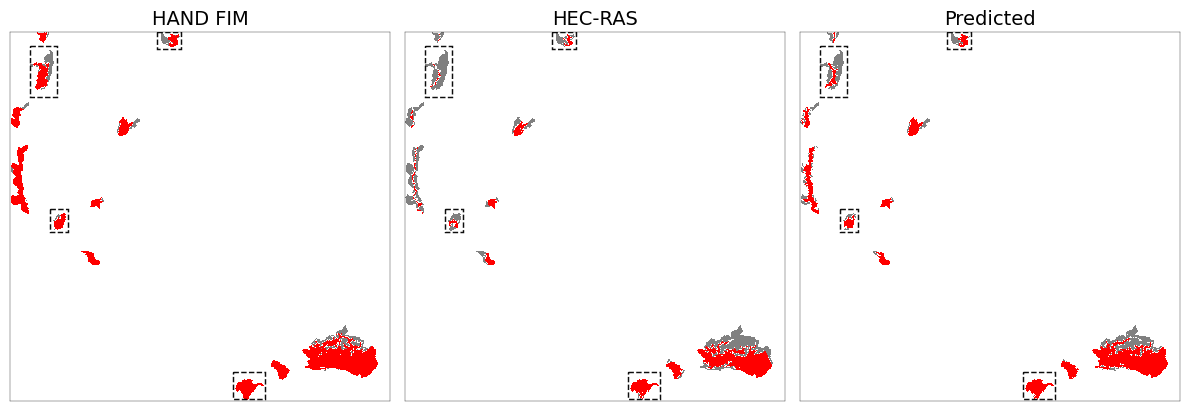

In [29]:
import matplotlib.colors as colors

cmap = colors.ListedColormap(['gray', 'white', 'red'])

def map_colors(data):
    return cmap([(data == -1)*0 + (data == 0)*1 + (data == 1)*2])

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

ax = axs[0]
ax.set_title('HAND FIM', fontsize=14)
im = ax.imshow(data_X_list[0], cmap=cmap)

ax = axs[1]
ax.set_title('HEC-RAS', fontsize=14)
im = ax.imshow(data_hec, cmap=cmap)

ax = axs[2]
ax.set_title('Predicted', fontsize=14)
im = ax.imshow(ymatr, cmap=cmap)

from matplotlib import patches

for ax in axs.flatten():
    for spine in ax.spines.values():
        spine.set_linewidth(0.25)
    ax.set_xticks([])
    ax.set_yticks([])
    rectangle_test_list = [patches.Rectangle((290, 200), 400, 750, 
                                       linewidth=1.05, edgecolor='k', 
                                       facecolor='none', linestyle='--', alpha=.95),
                           patches.Rectangle((2180, 0), 350, 250, 
                                       linewidth=1.05, edgecolor='k', 
                                       facecolor='none', linestyle='--', alpha=.95),
                           patches.Rectangle((590, 2620), 270, 330, 
                                       linewidth=1.05, edgecolor='k', 
                                       facecolor='none', linestyle='--', alpha=.95),
                           patches.Rectangle((3300, 5030), 480, 400, 
                                       linewidth=1.05, edgecolor='k', 
                                       facecolor='none', linestyle='--', alpha=.95)]
    for rectangle_test in rectangle_test_list:
        ax.add_patch(rectangle_test)
    
plt.tight_layout()

plt.show()